In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from statistics import mean
import math

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,DateTime, extract

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
session.query(Measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7feae218f250>,
 'id': 1,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01'}

In [10]:
session.query(Station).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7feae218fc40>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [11]:
# sqlStr = "SELECT m.date, m.prcp from Measurement as m "
# sqlStr += "Order by date desc"
results = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).first()


In [12]:
results

('2017-08-23', 0.0)

In [13]:
lastDateStr = results[0]
lastDate = dt.datetime.strptime(lastDateStr,"%Y-%m-%d")
firstDate = lastDate - dt.timedelta(days=365.25)
firstDateStr = firstDate.strftime('%Y-%m-%d')
print(f"{firstDateStr} to {lastDateStr}")

2016-08-22 to 2017-08-23


In [14]:
results = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).all()
df = pd.DataFrame(results)
df.replace([None],[0.0])
df.fillna(0)
df.dropna(how='any')
df.date = [dt.datetime.strptime(d,"%Y-%m-%d") for d in df.date]

In [15]:
df

,date,prcp
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45
4,2017-08-22,0.00
...,...,...
19545,2010-01-01,0.21
19546,2010-01-01,0.15
19547,2010-01-01,0.15
19548,2010-01-01,0.05


In [16]:
df_1year = df[df.date > firstDate]

df_1year_group = df_1year.groupby("date").agg("prcp").max()

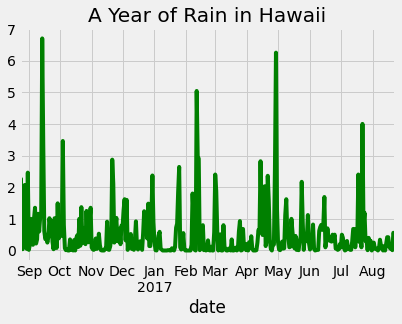

In [17]:
fig = df_1year_group.plot(
title = "A Year of Rain in Hawaii",
color = "Green")

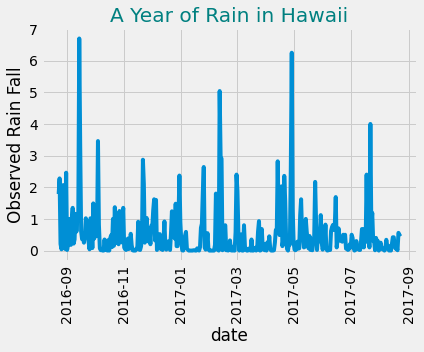

In [18]:
plt.plot(df_1year_group.index, df_1year_group)
plt.xlabel("date")
plt.xticks(rotation="vertical")
plt.ylabel("Observed Rain Fall") 
plt.title("A Year of Rain in Hawaii", color="teal")
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_1year.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(Measurement.station).all()



numOfStations = len(stations)
print(f"Number of Stations: {numOfStations}")

Number of Stations: 9


In [21]:
sqlStr = "Select m.station, s.name, count(m.prcp) as stationCount "
sqlStr += "FROM measurement as m "
sqlStr += "left Join station as s on m.station = s.station "
sqlStr += "Group by s.station "
sqlStr += "order by stationCount desc"

df = pd.read_sql_query( sqlStr, engine)

What are the most active stations? (i.e. what stations have the most rows)?

List the stations and the counts in descending order.


In [22]:
df

,station,name,stationCount
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00513117,"KANEOHE 838.1, HI US",2696
2,USC00519397,"WAIKIKI 717.2, HI US",2685
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2572
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2484
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1937
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1932
7,USC00517948,"PEARL CITY, HI US",683
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",342


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
mostActive = df.iloc[0,0]
actName = df.iloc[0,1]

results = session.query(Measurement.tobs).filter(Measurement.station == mostActive).all()
result2 = np.array(results).flatten()

In [24]:

mx = max(result2)
mn = min(result2),
avg = np.mean(result2)

print(f"{actName}(station {mostActive}) has a measured: \nmin temperature of {mn}°F\nmax temperature of {mx}°F \nave temperature of {avg:.1f}°F")

WAIHEE 837.5, HI US(station USC00519281) has a measured: 
min temperature of (54.0,)°F
max temperature of 85.0°F 
ave temperature of 71.7°F


In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# sqlStr = "Select m.station,  count(m.tobs) as counts, m.tobs , DateTime(m.date) as date "
# sqlStr += "FROM measurement as m "
# sqlStr += "where m.station = '" + mostActive + "'" 
# sqlStr += " and date > Date( " +firstDateStr +")"

result = session.query( Measurement.date, func.avg(Measurement.tobs)).group_by(Measurement.date).filter(Measurement.date > firstDateStr).filter(Measurement.station == mostActive).order_by(Measurement.date).all()
df3 = pd.DataFrame(result,columns=["Date", "Temperature"])


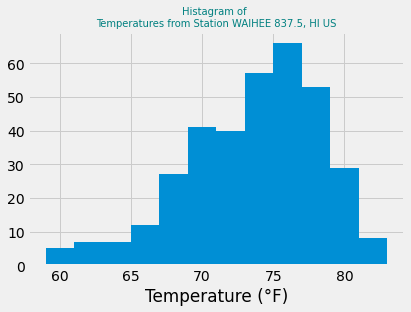

In [26]:
plt.hist(df3.Temperature,bins=12,width=2)
plt.title(f"Histagram of \nTemperatures from Station {actName}", size = 10, color = "teal")
plt.xlabel("Temperature (°F)")
plt.show()

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    results =  session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    (x,y,z) = results[0]
    print(x,y,z)
    return results
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

62.0 69.57142857142857 74.0
[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps(firstDateStr, lastDateStr))

58.0 74.59901654000895 87.0
[(58.0, 74.59901654000895, 87.0)]


In [29]:
from scipy.stats import stats

In [30]:
june_results = session.query(extract('month',Measurement.date),Measurement.tobs).filter(extract('month', Measurement.date) == '6' ).all()

dec_results = session.query(extract('month',Measurement.date),Measurement.tobs).filter(extract('month', Measurement.date) == '12' ).all()



In [31]:
june = pd.DataFrame(june_results, columns=["month", "Temp"])
dec = pd.DataFrame(dec_results, columns=["month", "Temp"])
N1 = len(june)
N2 = len(dec)
N = (N1 + N2)/2

In [32]:
june_ave = june.Temp.mean()
dec_ave = dec.Temp.mean()
june_pp = june.Temp.max()-june.Temp.min()
dec_pp = dec.Temp.max()- dec.Temp.min()
june_var = june.Temp.var(ddof=1)
dec_var = dec.Temp.var(ddof=1)


In [33]:
print(june_ave,june_pp, dec_ave,dec_pp)

74.94411764705882 21.0 71.04152933421226 27.0


In [34]:
stats.ttest_ind(june['Temp'],dec['Temp'])

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

#### Results
the p-value of 4e-191 indicates that there is a significate difference in the temperatures in June vs the temperatures in December

<BarContainer object of 2 artists>

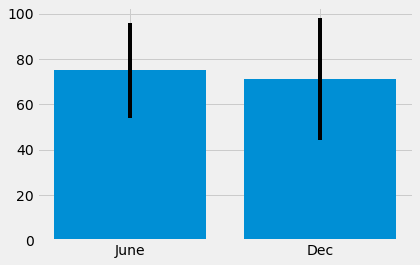

In [35]:
plt.bar(["June","Dec"],[june_ave,dec_ave],yerr= [june_pp, dec_pp])

In [36]:
trip_date_str = "2017-06-15"

In [37]:
trip_date = dt.datetime.strptime(trip_date_str,"%Y-%m-%d")
prev_date = trip_date - dt.timedelta(days=365.25)
prev_date_str = prev_date.strftime('%Y-%m-%d')
print(f"{prev_date_str} to {trip_date_str}")

2016-06-14 to 2017-06-15


In [38]:
(trip_min, trip_ave, trip_max)  = calc_temps(prev_date_str,trip_date_str)[0]
trip_pp = trip_max - trip_min

58.0 74.53010471204189 87.0


Text(0.5, 1.0, 'Trip Average Temp')

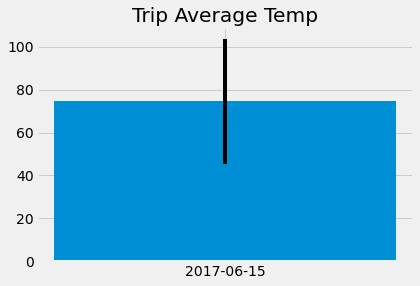

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(trip_date_str,trip_ave,yerr= trip_pp)
plt.title("Trip Average Temp")

In [40]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

results = session.query(Measurement.station, 
                        Measurement.prcp, Station.name, 
                        Station.latitude, 
                        Station.longitude, 
                        Station.elevation).group_by(Measurement.station).filter(Measurement.station == Station.station).\
                        filter(Measurement.date >= prev_date).\
                        filter(Measurement.date <= trip_date).order_by(Measurement.prcp.desc()).all()



In [41]:
df = pd.DataFrame(results)

In [42]:
df

,station,prcp,name,latitude,longitude,elevation
0,USC00516128,1.38,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,0.68,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00519523,0.25,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,USC00514830,0.18,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00513117,0.18,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
5,USC00517948,0.02,"PEARL CITY, HI US",21.39340,-157.97510,11.9
6,USC00519397,0.01,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


In [43]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [44]:
# calculate the daily normals for your trip
#trip_date = dt.datetime.strptime(trip_date_str,"%Y-%m-%d")
dates = []
date_tags = []
normals = []
for day in range(7):
    
    nextDate = trip_date + dt.timedelta(days=day)
    
    dates.append(nextDate)
    date_tag = nextDate.strftime("%m-%d")
    date_tags.append(date_tag)
    
    norm = daily_normals(date_tag)
    print(norm)
    normals.append(norm[0])
        
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Strip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

[(67.0, 75.40350877192982, 81.0)]
[(69.0, 75.41379310344827, 81.0)]
[(68.0, 74.59322033898304, 81.0)]
[(69.0, 74.60344827586206, 80.0)]
[(70.0, 75.44067796610169, 82.0)]
[(68.0, 73.96491228070175, 85.0)]
[(68.0, 74.75862068965517, 82.0)]


In [45]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_trip = pd.DataFrame(normals,columns=["norm_low", "norm_avg", "norm_hi"],index = dates)


In [46]:
df_trip

,norm_low,norm_avg,norm_hi
2017-06-15,67.0,75.403509,81.0
2017-06-16,69.0,75.413793,81.0
2017-06-17,68.0,74.593220,81.0
2017-06-18,69.0,74.603448,80.0
2017-06-19,70.0,75.440678,82.0
2017-06-20,68.0,73.964912,85.0
2017-06-21,68.0,74.758621,82.0


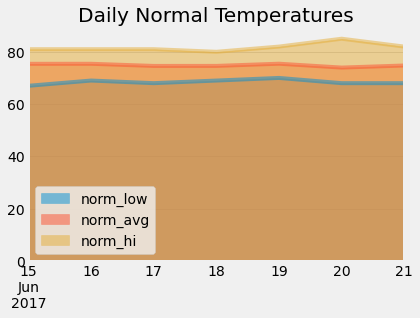

In [47]:
# Plot the daily normals as an area plot with `stacked=False`
ax = df_trip.plot.area(stacked=False, title="Daily Normal Temperatures")